Übung 3
------------

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import cv2
%matplotlib inline

**Helper Functions**

In [2]:
def add_noise(image, sigma):
    mean = 0
    gauss = np.random.normal(mean,sigma, image.shape)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    noisy = noisy.astype(np.uint16)
    return noisy

""" kwargs are passed through to plt.imshow()"""
def show_imgs(imgs, captions=None, **kwargs):
    n_imgs = len(imgs)
    if not captions:
        captions = ["" for _ in range(n_imgs)]
    assert n_imgs == len(captions), "imgs and captions have different lengths!"
    fig, axes = plt.subplots(1, n_imgs)
    fig.set_size_inches(8 * n_imgs, 10.5)
    axes = np.array(axes).reshape(-1) #subplots(...) doesn't return a list if n_imgs==1
    for idx, ax in enumerate(axes):
        img = imgs[idx]
        is_gray = len(img.shape) == 2 and not 'cmap' in kwargs
        if is_gray:
            kwargs['cmap']='gray'
        ax.imshow(imgs[idx], **kwargs)
        ax.set_title(captions[idx])
        ax.axis('off')
    fig.tight_layout()

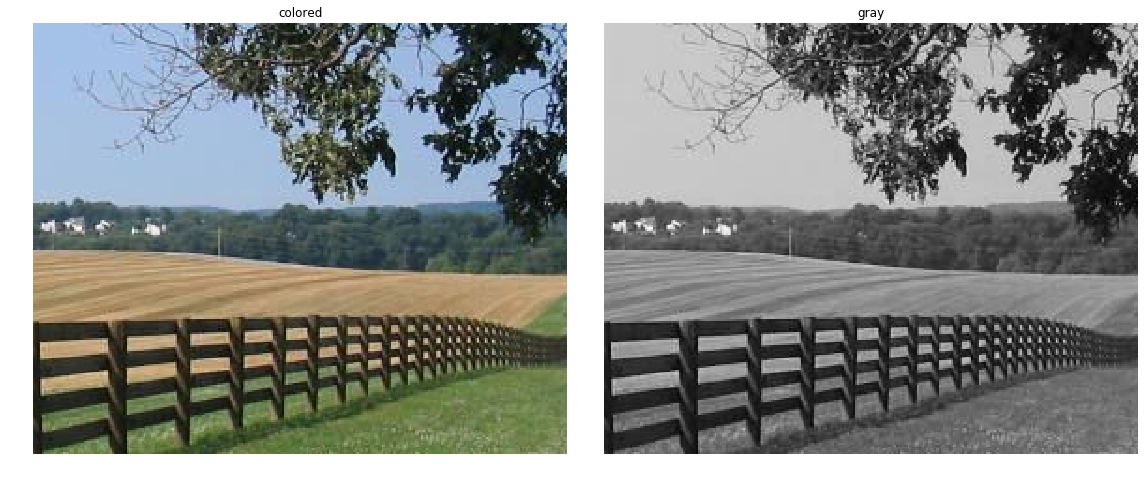

In [3]:
# prepare images
# filename = "fence.png"
filename = "fence_cropped.png"# use a cropped image to reduce computation time
img = cv2.imread(filename)
resolution = np.array(img.shape[:2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_imgs(
    [img, img_gray],
    ['colored', 'gray']
)

### 3.1 Median-Filter (10 Punkte)
Der Median-Filter ist ein einfacher nichtlinearer Filter, der sich gut eignet, um bestimmte Arten von
Bildrauschen zuentfernen.

* Implementiere einen Median-Filter, ohne medianBlur zu verwenden.

In [4]:
median_2d_vectorized = np.vectorize(np.median, signature='(n,m)->()')
def median_filter(in_img, k_size):
    assert len(in_img.shape) == 2, "img must be 2D"
    out_shape = np.array(in_img.shape) - [k_size, k_size] + [1, 1]
    neighborhoods = np.array([[
        in_img[row:row+k_size, col:col+k_size]
        for col in range(out_shape[1]) ]
        for row in range(out_shape[0])])
    out_img = median_2d_vectorized(neighborhoods)
    return out_img

* Wende den Median-Filter auf ein Graustufenbild an.

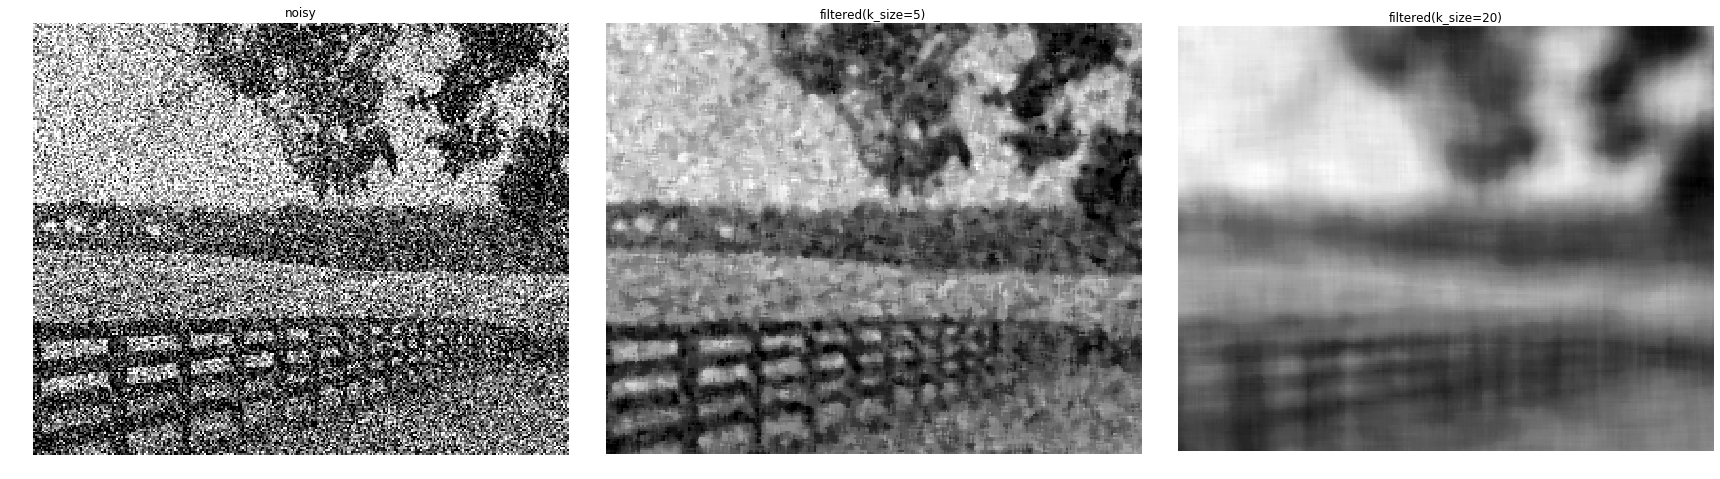

In [5]:
img_gray_noisy = add_noise(img_gray, 80)
img_gray_filtered_5 = median_filter(img_gray_noisy, 5)
img_gray_filtered_20 = median_filter(img_gray_noisy, 20)
show_imgs(
    [img_gray_noisy, img_gray_filtered_5, img_gray_filtered_20],
    ["noisy", "filtered(k_size=5)", "filtered(k_size=20)"])

* Wende den Median-Filter auf die einzelnen Kanäle eines Farbbilds an

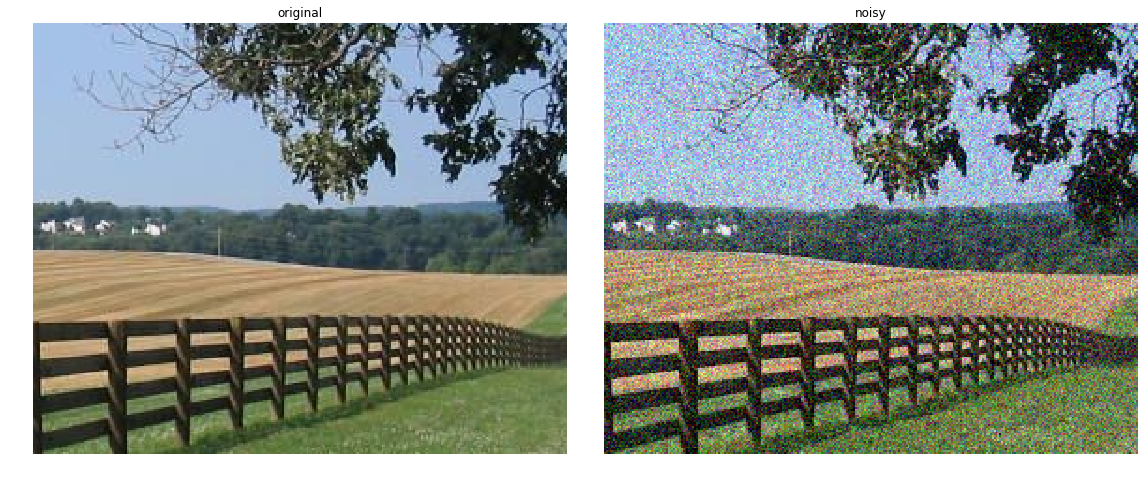

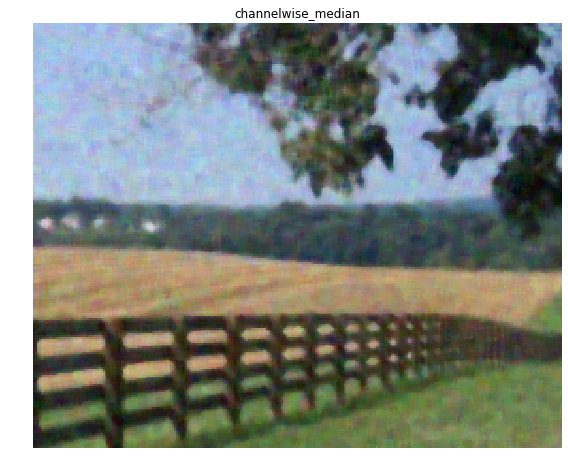

In [6]:
kernel_size = 5
img_noisy = add_noise(img, 30)
r_channel = img_noisy[:,:,0]
g_channel = img_noisy[:,:,1]
b_channel = img_noisy[:,:,2]
channels = [r_channel, g_channel, b_channel]
filtered_resolution = resolution - [kernel_size, kernel_size] + [1, 1]
channelwise_median = np.zeros([*filtered_resolution, 3], dtype=np.uint16)
for idx, ch in enumerate(channels):
    channelwise_median[:,:,idx] = median_filter(ch, kernel_size)
show_imgs([img, img_noisy], ['original', 'noisy'])
show_imgs([channelwise_median], ['channelwise_median'])

* Wie kann man ungewollte Farbverschiebungen vermeiden?


Nur ganze Pixel aus dem Bild nehmen, nicht "mischen".  
Problem: Median eines Vektors $[r, g, b]^T$  
Siehe [Wikipedia](https://de.wikipedia.org/wiki/Vektor-Medianfilter)  
**TODO: implementieren**

* Für welche Arten von Rauschen eignet sich der Median-Filter gut, für welche nicht?

**TODO**

### 3.2 Hough-Transformation (10 Punkte)  
Die Hough-Transformation kann für das Finden von Linien in Bildern verwendet werden.
In dieser Aufgabe sollst du die Hough-Transformation implementieren ohne die Funktionen HoughLines
oder HoughLinesP zu verwenden.


* Erzeuge ein Kantenbild. Verwende dazu einen Filter deiner Wahl. Begründe die Wahl des Kantendetektors.


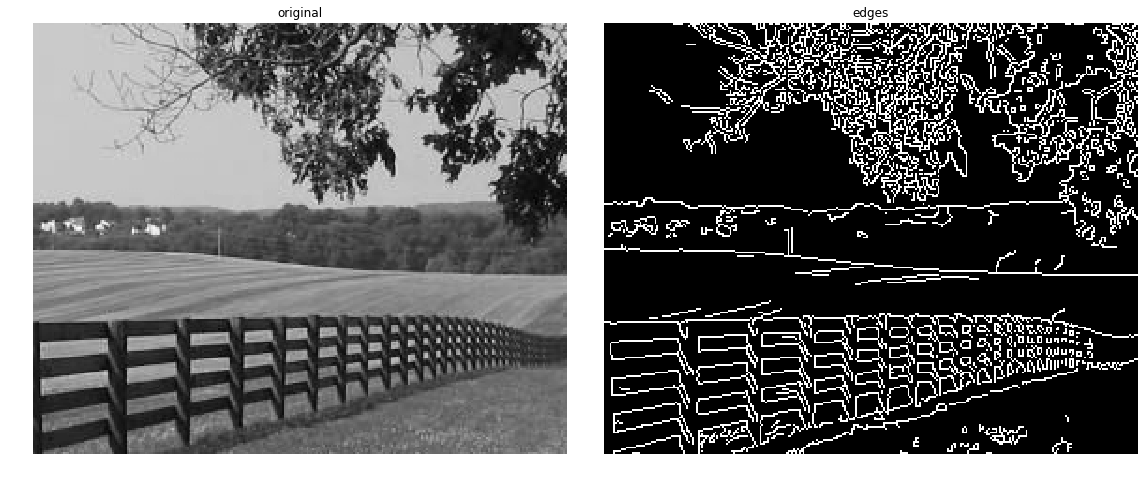

In [7]:
edges = cv2.Canny(img_gray, 100, 200)
show_imgs([img_gray, edges], ['original', 'edges'])

* Transformiere das Kantenbild in den Hough-Raum und zeige diesen in einer geeigneten Color Map
an.

[Erklärung + Beispielcode](https://alyssaq.github.io/2014/understanding-hough-transform/)

In [8]:
os       = np.deg2rad(np.arange(-90, 90))
def hough_transform(img):
    sin_o    = np.sin(os)
    cos_o    = np.cos(os)
    max_dist = np.ceil(linalg.norm(img.shape)).astype(np.uint64)
    accumulator = np.zeros([int(2*max_dist), len(os)])
    points   = list(zip(*np.nonzero(img)))
    for x, y in points:
        for o_idx, o in enumerate(os):
            sinx, cosx = sin_o[o_idx], cos_o[o_idx]
            dist = x * cosx + y * sinx
            accumulator[int(round(dist+max_dist)), o_idx] += 1
    return accumulator

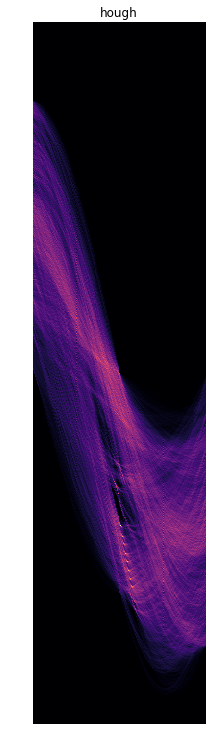

In [9]:
hough = hough_transform(edges)
show_imgs([hough], ["hough"], cmap='magma')

*  Finde die markantesten Linien und zeichne diese in das Originalbild ein.

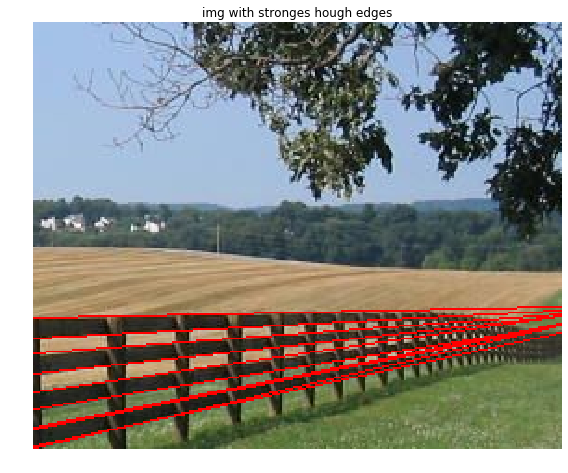

In [10]:
inf = 1000
hough_thr = hough > 100
dists_, o_idxs = np.nonzero(hough_thr)
max_dist = np.ceil(linalg.norm(img.shape)).astype(np.uint64)
img_hough_line = img.copy()
for dist_, o_idx in zip(dists_, o_idxs):
    rho = dist_ - max_dist
    theta = os[o_idx]
    cos_o = np.cos(theta)
    sin_o = np.sin(theta)
    x0 = sin_o*rho
    y0 = cos_o*rho
    x1 = int(x0 + inf*(cos_o))
    y1 = int(y0 + inf*(-sin_o))
    x2 = int(x0 - inf*(cos_o))
    y2 = int(y0 - inf*(-sin_o))
    cv2.line(img_hough_line,(x1,y1),(x2,y2),(255, 0, 0),1)
    
show_imgs([img_hough_line], ['img with stronges hough edges'])